# Steiner Trees (STs)

A Steiner tree is a concept stemming from combinatorial optimization that seeks to connect a given set of vertices (or nodes) in the shortest possible total distance, but with the added provision that additional nodes not in the original set can be included if they reduce the overall connecting distance. 

Given a weighted graph $ G = (V, E) $ and a subset $ T \subseteq V $ of terminal vertices, the goal of the Steiner Tree problem is to find a tree of minimum weight in $ G $ that spans all vertices in $ T $. This tree can include vertices not in $ T $, and these additional vertices are called Steiner vertices. The objective is to connect all the terminals using the shortest possible total edge weight.

One notable application of Steiner trees is in the analysis and modeling of biological networks. By using Steiner trees, researchers can identify minimal subnetworks that connect a given set of proteins or genes, potentially pinpointing previously unobserved or unknown elements (analogous to the Steiner points) that play crucial roles in these networks. Such insights can help in understanding disease mechanisms, drug targets, and the fundamental underpinnings of biological processes.

The Steiner tree problem, like many other combinatorial challenges, is an NP-hard optimization problem. This implies that finding optimal solutions for large instances of the problem can be computationally hard. To tackle this, numerous heuristic methods have been developed which offer reasonably good solutions within an acceptable timeframe. However, many of these methods are typically tailored for specific cases, for example undirected graphs. Certain assumptions inherent in these methods can make them difficult to modify or adapt for different problem scenarios.

CORNETO stands as a robust tool in this realm, offering flexible modeling capabilities for Steiner trees. By modelling steiner tree problems as Integer Linear Programming problems, CORNETO offers a more advanced and flexible approach to modeling Steiner trees. This allows users to model and solve Steiner tree problems in a variety of ways, including:

- **Directed/undirected edge support**: Unlike many tools that restrict you to either directed or undirected edges, CORNETO supports both simultaneously. This is particularly useful when modeling systems where interactions can be both reciprocal (undirected) and one-way (directed), which is often the case in biological networks.

- **Solution flexibility**: With CORNETO, users can decide how strict they want to be with their Steiner tree solutions.
    - For cases where only Steiner tree solutions are acceptable, CORNETO can enforce infeasibility for non-Steiner trees. This means every solution provided, even if not the best possible, will always be a valid Steiner tree.
    - Alternatively, if users prefer to explore a broader range of solutions before arriving at an optimal Steiner tree, CORNETO permits non-Steiner tree solutions. Only the optimal solution, once identified, is guaranteed to be a true Steiner tree.

- **Problem extensions**: By transparently modeling the Steiner tree problem as an Integer Linear Programming task in CORNETO, users gain the flexibility to introduce additional constraints or modify the objective function as they wish. For instance, they can set a limit on the number of Steiner points included in the solution or define a maximum distance between any two nodes within that solution. This adaptability enables users to customize the problem according to their unique requirements.

In this tutorial, we will demonstrate how to model and solve undirected Steiner tree problems using CORNETO. We will use a small example network to illustrate the process, and we will compare the solutions with those obtained with the very well known `networkx` graph library.

## Heuristic steiner tree from NetworkX

First, we will create a random undirected graph with random weights between 1 an 10. Then we will run the heuristic steiner tree algorithm from NetworkX to see which solution it finds.

In [1]:
import networkx as nx
import numpy as np
from networkx.algorithms.approximation import steiner_tree


# Generate a random graph with networkx

def create_random_graph(n_nodes, prob, seed=0):
    np.random.seed(seed)
    random_graph = nx.erdos_renyi_graph(n_nodes, prob, seed=seed)
    weights = np.random.randint(1, 10, len(random_graph.edges))
    edges_r = list(random_graph.edges())
    for i, weight in enumerate(weights):
        edge = edges_r[i]
        random_graph[edge[0]][edge[1]]['weight'] = weight
    return random_graph

random_graph = create_random_graph(50, 0.1)

/home/runner/.cache/pypoetry/virtualenvs/corneto-lU1q7eKj-py3.11/lib/python3.11/site-packages/networkx/utils/decorators.py:770: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.
  return argmap._lazy_compile(__wrapper)(*args, **kwargs)


Cost: 45


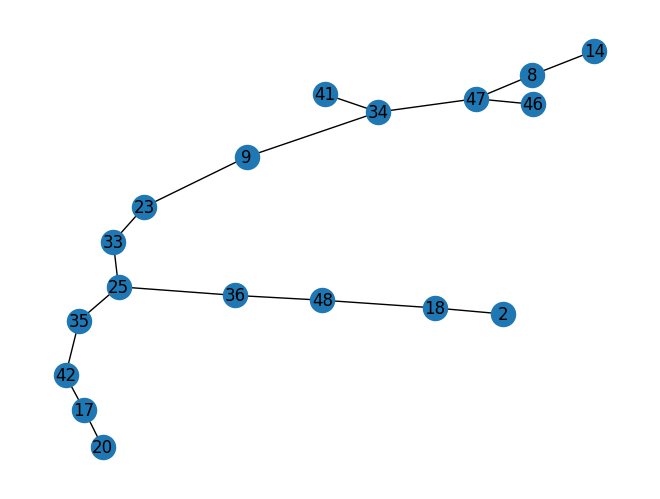

In [2]:
# Select 10 random vertices from the networkx graph as terminal nodes:

terminals = np.random.choice(random_graph.nodes, size=10, replace=False)
stree = steiner_tree(random_graph, terminals)
total_weight = sum(random_graph[u][v]['weight'] for u, v in stree.edges)
print("Cost:", total_weight)
nx.draw(stree, with_labels=True)

We need to check if the solution is the optimal one or not. **Since we've used an heuristic (but fast) method, we don't have any proof about optimality**. We will see now how CORNETO can be used to get a better solution (which is also the optimal). Due to CORNETO's exact modeling of the problem, and the use of advanced mathematical solvers, we can not only achieve a solution superior to that of NetworkX, but also have the guarantees that the solution is optimal and no better network exists. 

## Exact Steiner Trees with CORNETO

Now, we will do the same using CORNETO to convert the random graph to a corneto graph and then we will create an ILP steiner tree problem, which is exact, and we will solve it using the SCIP solver (open source).


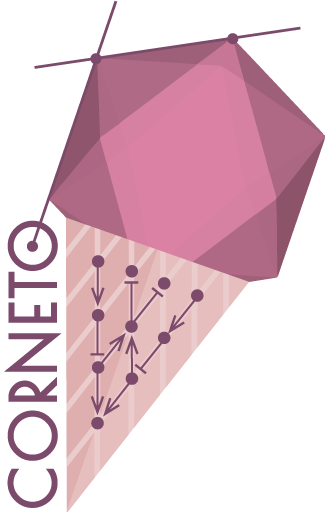

In [3]:
import corneto as cn
cn.info()

We need some code to convert the `networkx` graph into a `corneto` Graph:

In [4]:
from corneto._graph import EdgeType
def to_graph(nx_graph, weights=None, directed=False):
    G = cn.Graph()
    if weights is None:
        weights = [e[2].get('weight', 0) for e in nx_graph.edges(data=True)]
    for e, w in zip(nx_graph.edges, weights):
        etype = EdgeType.DIRECTED if directed else EdgeType.UNDIRECTED
        G.add_edge(e[0], e[1], weight=w, type=etype)
    return G

G = to_graph(random_graph)
G.shape


(50, 145)

We will use the `exact_steiner_tree` method. This method converts the original graph into a network flow problem equivalent to the steiner tree problem. The method returns the optimization problem and a new graph, which is an augmented version of the original graph, containing few extra edges required for the network flow problem

In [5]:
from corneto.methods.steiner import exact_steiner_tree

P, G_steiner = exact_steiner_tree(G, terminals)

# The problem contains two vector variables, _flow and _flow_i.
# _flow is the normal _flow variable to define a network flow problem on the graph.
# _flow_i is an indicator binary vector. If _flow_i[i] = 1, then _flow[i] = 0.
# The _flow_i variable contains the edges that are selected in the Steiner tree.
P.symbols

{'_flow': Variable((155,), _flow),
 '_flow_i': Variable((155,), _flow_i, boolean=True)}

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) Apr 25 10:47:26 AM: Your problem has 310 variables, 7 constraints, and 0 parameters.
(CVXPY) Apr 25 10:47:26 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 25 10:47:26 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 25 10:47:26 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 25 10:47:26 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:47:26 AM: Compiling problem (target solver=SCIPY).
(C

(CVXPY) Apr 25 10:47:26 AM: It is compliant with the following grammars: DCP, DQCP


(CVXPY) Apr 25 10:47:26 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)


(CVXPY) Apr 25 10:47:26 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


(CVXPY) Apr 25 10:47:26 AM: Your problem is compiled with the CPP canonicalization backend.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:47:26 AM: Compiling problem (target solver=SCIPY).


(CVXPY) Apr 25 10:47:26 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIPY


(CVXPY) Apr 25 10:47:26 AM: Applying reduction Dcp2Cone


(CVXPY) Apr 25 10:47:26 AM: Applying reduction CvxAttr2Constr


(CVXPY) Apr 25 10:47:26 AM: Applying reduction ConeMatrixStuffing


(CVXPY) Apr 25 10:47:26 AM: Applying reduction SCIPY


(CVXPY) Apr 25 10:47:26 AM: Finished problem compilation (took 1.438e-02 seconds).


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:47:26 AM: Invoking solver SCIPY  to obtain a solution.


Solver terminated with message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:48:00 AM: Problem status: optimal


(CVXPY) Apr 25 10:48:00 AM: Optimal value: 4.100e+01


(CVXPY) Apr 25 10:48:00 AM: Compilation took 1.438e-02 seconds


(CVXPY) Apr 25 10:48:00 AM: Solver (including time spent in interface) took 3.394e+01 seconds


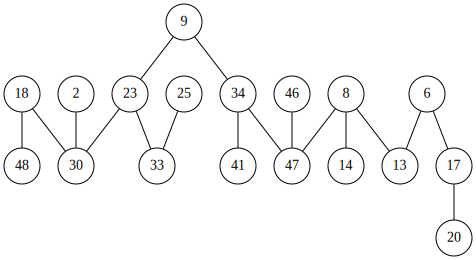

In [6]:
P.solve(solver='SCIPY', verbosity=1)
G_steiner.edge_subgraph(np.where(P.symbols['_flow_i'].value > 0.5)[0]).plot(orphan_edges=False)

In [7]:
# The cost is lower than the solution we obtained with networkx
P.objectives[0].value

40.999999999999986

The Steiner problem is only guaranteed to yield a Steiner tree when we allow the solver to run until optimality is proven. However, we can enforce the tree structure more strictly by setting `strict_acyclic=True`. In this scenario, instead of using a standard network flow problem, it employs an acyclic network flow. While this approach introduces more variables, it also adds more constraints. These additional constraints exclude many structures that aren't trees from the feasible space, potentially aiding solvers in finding the optimal solution more quickly. Moreover, we can stop the solver early, even before optimality is confirmed, and still obtain a valid Steiner tree.

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) Apr 25 10:48:00 AM: Your problem has 670 variables, 17 constraints, and 0 parameters.
(CVXPY) Apr 25 10:48:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 25 10:48:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 25 10:48:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 25 10:48:00 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:48:00 AM: Compiling problem (target solver=SCIPY).
(

(CVXPY) Apr 25 10:48:00 AM: It is compliant with the following grammars: DCP, DQCP


(CVXPY) Apr 25 10:48:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)


(CVXPY) Apr 25 10:48:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


(CVXPY) Apr 25 10:48:00 AM: Your problem is compiled with the CPP canonicalization backend.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:48:00 AM: Compiling problem (target solver=SCIPY).


(CVXPY) Apr 25 10:48:00 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIPY


(CVXPY) Apr 25 10:48:00 AM: Applying reduction Dcp2Cone


(CVXPY) Apr 25 10:48:00 AM: Applying reduction CvxAttr2Constr


(CVXPY) Apr 25 10:48:00 AM: Applying reduction ConeMatrixStuffing


(CVXPY) Apr 25 10:48:00 AM: Applying reduction SCIPY


(CVXPY) Apr 25 10:48:00 AM: Finished problem compilation (took 2.385e-02 seconds).


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:48:00 AM: Invoking solver SCIPY  to obtain a solution.


Solver terminated with message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Apr 25 10:48:17 AM: Problem status: optimal


(CVXPY) Apr 25 10:48:17 AM: Optimal value: 4.100e+01


(CVXPY) Apr 25 10:48:17 AM: Compilation took 2.385e-02 seconds


(CVXPY) Apr 25 10:48:17 AM: Solver (including time spent in interface) took 1.726e+01 seconds


Optimal value: 41.0


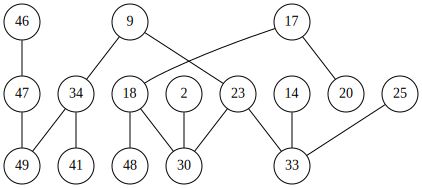

In [8]:
P, G_steiner = exact_steiner_tree(G, terminals, strict_acyclic=True)
P.solve(solver='SCIPY', verbosity=1)
print("Optimal value:", P.objectives[0].value)
G_steiner.edge_subgraph(np.where(P.symbols['_flow_i'].value > 0.5)[0]).plot(orphan_edges=False)